Created 5.19.20

Authors: Margot Wagner, Sam Russman

COGS 260 Neural Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from math import ceil

%matplotlib inline

# 1. Load dataset

#### Format data as matrix "X" of samples x features
- X starts as [n_chans x n_tp x n_samples x n_conditions] = [360 x 51 x 21 x 4]
- In this case we are splitting the baselines into two separate conditions

In [37]:
def load_data(filename, transpose=False):
    '''
    Load in data and return values
    
    param:   filename (str) - filename/path to data
             transpose - transposes data if true (default False)
    return:  data - data values (n_samples, n_features) 
    '''
    data = pd.read_csv(filename, header=None)
    
    # needs to be samples x features
    if transpose:    
        data = data.transpose()
        
    return data.values

In [38]:
'''Create X matrix'''
N_CHANS = 360
N_TIMEPTS = 51
N_SAMPLES = 21
N_CONDITIONS = 4
X = np.zeros((N_CHANS, N_TIMEPTS, N_SAMPLES, N_CONDITIONS))
L_COND_IDX = 0
R_COND_IDX = 1
NO_COND_IDX_1 = 2   # first half of baseline samples
NO_COND_IDX_2 = 3   # second half of baselines samples
IDX_SHIFT = 1       # index adjustments due to zero indexing

# 60mA stim and baseline
os.chdir('/Volumes/GoogleDrive/Shared drives/COGS 260 Project/Data/fragments3')
files = glob.glob('*60mA*') + glob.glob('baseline*')

# Sample numbers
l_i = 0
r_i = 0
no_i = 0
for filename in files:
    data = load_data(filename)
    
    # If data is from left condition, place in first condition index of X
    if '_l_' in filename:
        X[:, :, l_i, L_COND_IDX] = data
        l_i += 1    # increment left sample number
        
    # If data is from right condition, place in second condition index of X
    elif '_r_' in filename:
        X[:, :, r_i, R_COND_IDX] = data
        r_i += 1    # incremenet right sample number
        
    # If data is no stimulus condition, place in third condition index of X
    else:
        # Once condition 3 has 21 total samples, starting addition to condition 4
        if no_i <= (N_SAMPLES - IDX_SHIFT):
            X[:, :, no_i, NO_COND_IDX_1] = data
            no_i += 1    # increment no stim sample number
        else:
            X[:, :, no_i%(N_SAMPLES), NO_COND_IDX] = data
            no_i += 1    # increment no stim sample number
    
print("All data, X:", X.shape)   

All data, X: (360, 51, 21, 4)


#### Reshape to 2D matrix
- Reshape to X starts as [n_chans * n_tp x n_samples * n_conditions] = [360 * 51 x 21 * 4]
- After reshaping, we transpose the matrix, so the data matrix is of size n x p, where n is the number of samples and p is the number of variables/observations/features.
- We also want to center the data, so that the column/features means have been subtracted and are now equal to zero.


In [39]:
def reshape(X, transpose=True, center=True):
    '''
    Reshape, transpose, and center data matrix for PCA
    
    params
        X - data matrix
        transpose - if X needs to be transposed
        center - if X needs to be centers
        
    return
        X - data matrix, reshaped, transposed, and centered
    '''
    
    X = np.reshape(X, (N_CHANS*N_TIMEPTS, N_SAMPLES*N_CONDITIONS))
    
    if transpose:
        # Want X to be samples/observations x features
        X = X.T
        
    if center:
        # Remove column means
        X = X - np.mean(X, axis=0)
        
    return X
    

In [40]:
X = reshape(X)

# 2. Apply SVD

SVD gives X = USV^T where X is an n x p matrix
U 
- Unitary matrix, square matrix where U*U = UU* = I
- Orthogonal
- n x d
    
S 
- Diagonal matrix of singular values
- d x d 

V
- Singular matrix containing orthogonal vectors of unit length in its column
- Orthogonal
- d x r

V gives the principal directions/axes  
XV = US columns are the principal components/scores

In [50]:
'''Compute SVD of the original matrix'''
# Keep eigenvectors that have the top kth highest singular value (PCA)
print("X is samples x features", X.shape)
u, s, vh = np.linalg.svd(X, full_matrices=False)

# X = USV^T
v = vh.T

X is samples x features (84, 18360)


In [51]:
print(u.shape)
print(s.shape)
print(vh.shape)
print(v.shape)

(84, 84)
(84,)
(84, 18360)
(18360, 84)


In [109]:
# Singular values
s
print("Singular values shape", s.shape)

# components
principal_axes = v
print("Components shape", principal_axes.shape)

# transformed data (both work)
us = (u*s)
xv = np.dot(X, v)
X_transformed = xv
print("Transformed data shape", X_transformed.shape)

# explained variance
var = (s**2)/sum(s**2)
cum_var = np.cumsum(var)
print(cum_var)

Singular values shape (84,)
Components shape (18360, 84)
Transformed data shape (84, 84)
[0.79791057 0.84245665 0.87353006 0.89775907 0.91296732 0.92434523
 0.93471191 0.94372119 0.95133658 0.95777259 0.96296823 0.96673879
 0.96975009 0.97220844 0.97440663 0.97628424 0.97809397 0.97976058
 0.98139902 0.98291331 0.98440748 0.98576696 0.9869991  0.98812273
 0.98915315 0.99013354 0.99102966 0.99180061 0.99247584 0.99305246
 0.99359717 0.99411397 0.99457479 0.99498765 0.99533483 0.99565841
 0.99597676 0.99628135 0.9965481  0.99679672 0.99704148 0.9972662
 0.99748113 0.99767843 0.9978743  0.99805667 0.99823098 0.99839984
 0.99855935 0.99871147 0.99885382 0.99898747 0.99911015 0.99922917
 0.9993375  0.99943969 0.99954017 0.99963207 0.99972156 0.99980481
 0.99988303 0.99995812 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.       

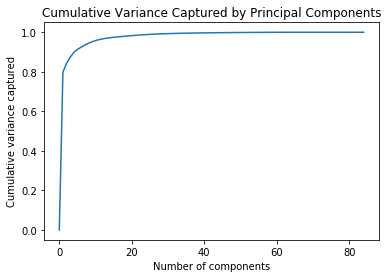

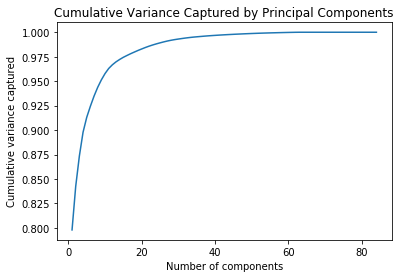

In [113]:
'''Cumulative variance plot'''
INDEX_SHIFT = 1

# With zero
plt.figure()
plt.plot(range(len(cum_var)+INDEX_SHIFT), np.insert(cum_var, 0, 0))
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance captured')
plt.title('Cumulative Variance Captured by Principal Components')

# Without zero
plt.figure()
plt.plot(range(INDEX_SHIFT,len(cum_var)+INDEX_SHIFT), cum_var)
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance captured')
plt.title('Cumulative Variance Captured by Principal Components')

plt.show()

# Biplot (TODO: ADD ALL COMBOS OF TOP 5 PC's)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)


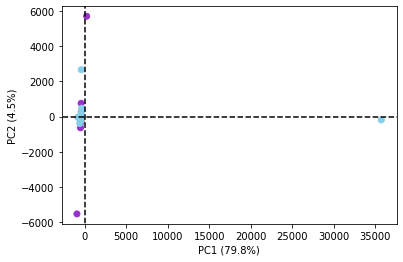

In [164]:
'''Biplot'''
from itertools import combinations
# Combinations of top 5 PC's
PC_MIN = 0   
PC_MAX = 5   # want top 5 pc's
N_PCS = 2    # look at 2 pc's at a time

# IDX of top 5 PC's
TOP_5 = np.arange(PC_MIN,PC_MAX)

combos = combinations(TOP_5, N_PCS)

# All combinations
for combo in list(combos):
    print(combo)

# TODO: Generalize to all combinations of PC's
# TODO: Add plot title and legend

# Example biplot for PC1 (index 0) and PC2 (index 1)
PC_IDX_1 = 0    # index of first PC
PC_IDX_2 = 1    # index of second PC

# PC's
pc_1 = X_transformed[:,PC_IDX_1]
pc_2 = X_transformed[:,PC_IDX_2]

# Colored by
labels = np.array(['left', 'right', 'none', 'none'])
labels = np.repeat(labels, N_SAMPLES)
colors = [{'left':'coral', 'right':'darkorchid', 'none':'skyblue'}[x] for x in labels]

# plotting
plt.figure()
plt.scatter(pc_1, pc_2, color=colors)
plt.xlabel('PC{0} ({1:.1%})'.format(PC_IDX_1 + INDEX_SHIFT, var[PC_IDX_1]))
plt.ylabel('PC{0} ({1:.1%})'.format(PC_IDX_2 + INDEX_SHIFT, var[PC_IDX_2]))

plt.axvline(x=0, ymin=np.min(pc_1), ymax=np.max(pc_1), color='k', ls='--')
plt.axhline(y=0, xmin=np.min(pc_2), xmax=np.max(pc_2), color='k', ls='--')

plt.show()

# Comparison with built-in packages (ignore below here)

In [70]:
from sklearn.decomposition import TruncatedSVD
svd_tr = TruncatedSVD(n_components=100)
svd_tr.fit(X)

# singular values
s_tr = svd_tr.singular_values_
print("Singular values shape", s_tr.shape)

# components
tr_components = svd_tr.components_
print("Components shape", tr_components.shape)
#print(components)

# transformed data
X_tr = svd_tr.transform(X)
print("Transformed data shape", X_tr.shape)
#print(X_tr)

Singular values shape (84,)
Components shape (84, 18360)
Transformed data shape (84, 84)


(84, 2)


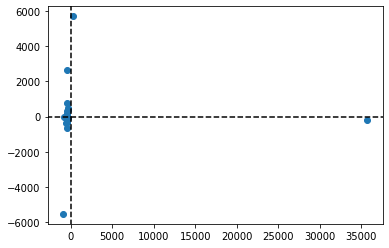

In [76]:
'''Biplot'''
PC1_IDX = 0    # index of first PC
PC2_IDX = 1    # index of second PC
DIM = 2        # dimensions to plot 

# top 2 pc's and their variance explained
#top_pcs = pca.transform(data)[:,:DIM]
top_2_pcs = X_tr[:,:DIM]
#top_var = pca.explained_variance_ratio_[:DIM]

# plotting
plt.figure()
plt.scatter(top_2_pcs[:,PC1_IDX], top_2_pcs[:,PC2_IDX])
#plt.xlabel('PC1 ({:.1%})'.format(top_var[PC1_IDX]))
#plt.ylabel('PC2 ({:.1%})'.format(top_var[PC2_IDX]))
plt.axvline(x=0, ymin=np.min(top_2_pcs[:,PC2_IDX]), ymax=np.max(top_2_pcs[:,PC2_IDX]), color='k', ls='--')
plt.axhline(y=0, xmin=np.min(top_2_pcs[:,PC1_IDX]), xmax=np.max(top_2_pcs[:,PC1_IDX]), color='k', ls='--')

#return top_pcs[:,PC1_IDX], top_var[PC1_IDX]

print(top_2_pcs.shape)

In [71]:
from sklearn.decomposition import PCA
print(X.T.shape)
pca = PCA()
pca.fit(X)

# singular values
s_pca = pca.singular_values_
print("Singular values shape", s_pca.shape)

# components
components = pca.components_
print("Components shape", components.shape)
#print(components)

# transformed data
X_pca = pca.transform(X)
print("Transformed data shape", X_pca.shape)
#print(X_pca)

(18360, 84)
Singular values shape (84,)
Components shape (84, 18360)
Transformed data shape (84, 84)


[0.79791057 0.84245665 0.87353006 0.89775907 0.91296732 0.92434523
 0.93471191 0.94372119 0.95133658 0.95777259 0.96296823 0.96673879
 0.96975009 0.97220844 0.97440663 0.97628424 0.97809397 0.97976058
 0.98139902 0.98291331 0.98440748 0.98576696 0.9869991  0.98812273
 0.98915315 0.99013354 0.99102966 0.99180061 0.99247584 0.99305246
 0.99359717 0.99411397 0.99457479 0.99498765 0.99533483 0.99565841
 0.99597676 0.99628135 0.9965481  0.99679672 0.99704148 0.9972662
 0.99748113 0.99767843 0.9978743  0.99805667 0.99823098 0.99839984
 0.99855935 0.99871147 0.99885382 0.99898747 0.99911015 0.99922917
 0.9993375  0.99943969 0.99954017 0.99963207 0.99972156 0.99980481
 0.99988303 0.99995812 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]
(84, 2)
[7.9791e+01 4.4550e+00 3.1070e+00 2.4230e+00 1.5210e+00 1.1380e+00
 1.0370e+00

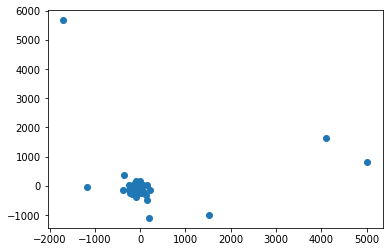

In [96]:
'''Biplot'''
PC1_IDX = 0    # index of first PC
PC2_IDX = 1    # index of second PC
DIM = 2        # dimensions to plot 

# top 2 pc's and their variance explained
#top_pcs = pca.transform(data)[:,:DIM]
top_2_pcs = X_pca[:,2:4]
top_var = pca.explained_variance_ratio_
cum_var = np.cumsum(top_var)
print(cum_var)

# plotting
plt.figure()
plt.scatter(top_2_pcs[:,0], top_2_pcs[:,1])
#plt.xlabel('PC1 ({:.1%})'.format(top_var[PC1_IDX]))
#plt.ylabel('PC2 ({:.1%})'.format(top_var[PC2_IDX]))
#plt.axvline(x=0, ymin=np.min(top_2_pcs[:,PC2_IDX]), ymax=np.max(top_2_pcs[:,PC2_IDX]), color='k', ls='--')
#plt.axhline(y=0, xmin=np.min(top_2_pcs[:,PC1_IDX]), xmax=np.max(top_2_pcs[:,PC1_IDX]), color='k', ls='--')

#return top_pcs[:,PC1_IDX], top_var[PC1_IDX]

print(top_2_pcs.shape)
print((top_var*100).round(3))

### PCA 

In [194]:
from sklearn.decomposition import PCA
def run_pca(data):
    '''
    Does PCA on normalized data set. Can optionally set fewer components
    
    param: data - normalized data (n_samples, n_features)
    return: 
        data_pc: data transformed onto princinpal components
        components:  principal axes in feature space, array, shape (n_components, n_features)
        weights: percentage of variance explained by each of the selected components. array, shape (n_components,)
    '''
    # create PCA model
    pca = PCA() 
    
    # fit model to data
    data_pc = pca.fit(data)  
    
    # obtain components and components' weights
    components = pca.components_
    weights = pca.explained_variance_ratio_
    
    return data_pc, components, weights, pca

In [196]:
def cum_var_plot(weights, desired_var, plot=False):
    '''
    Cumulative variance plot (number of components vs cumulative variance captured) with calculated number 
    of PCs required to get to a certain desired variance explained
    
    params:
        weights: percentage of variance explained by each of the selected components. array, shape (n_components,)
        desired_var:  percent variance to find number of PCs for
    return
        pcs_req:   pcs required to captured at least desired variance
        captured_var   exact variance captured by pcs_req
    
    '''
    INDEX_SHIFT = 1
    # cumulative variance captured
    cum_var = np.cumsum(weights) 
    
    # find pcs req to get desired variance
    pcs_req = int(round(np.min(np.where(cum_var > desired_var)) + 1)) 
    
    # actual variance captured
    captured_var = cum_var[pcs_req-INDEX_SHIFT]
    
    # plotting
    if plot:
        plt.figure()
        plt.plot(range(INDEX_SHIFT,len(cum_var)+INDEX_SHIFT), cum_var)
        plt.axvline(x=pcs_req, ymin=0, ymax=1, color='k', linestyle='--')
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative variance captured')
        plt.title('Cumulative Variance Captured by Principal Components')
    
    return pcs_req, captured_var

In [197]:
def biplot(data, pca, plot=False):
    '''
    Creates biplot for data mapping data onto top 2 or 3 principal components
    
    params
        data - normalized data, array shape (n_samples, n_features)
        pca - pca model
        
    return
        top_pcs[:,PC1_IDX] - pcs captured by top PC
        top_var[PC1_IDX] - variance captured by top PC
    '''
    PC1_IDX = 0    # index of first PC
    PC2_IDX = 1    # index of second PC
    DIM = 2        # dimensions to plot 
    
    # top 2 pc's and their variance explained
    top_pcs = pca.transform(data)[:,:DIM]
    top_var = pca.explained_variance_ratio_[:DIM]
    
    # plotting
    if plot:
        plt.figure()
        plt.scatter(top_pcs[:,PC1_IDX], top_pcs[:,PC2_IDX])
        plt.xlabel('PC1 ({:.1%})'.format(top_var[PC1_IDX]))
        plt.ylabel('PC2 ({:.1%})'.format(top_var[PC2_IDX]))
        plt.axvline(x=0, ymin=np.min(top_pcs[:,PC2_IDX]), ymax=np.max(top_pcs[:,PC2_IDX]), color='k', ls='--')
        plt.axhline(y=0, xmin=np.min(top_pcs[:,PC1_IDX]), xmax=np.max(top_pcs[:,PC1_IDX]), color='k', ls='--')
    
    return top_pcs[:,PC1_IDX], top_var[PC1_IDX]

# LDA Classification

In [295]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def classify(data, clf):
    '''
    General classifier for reduced input data into 
    3 stimulus conditions (left, right, no stimulus)
    
    param:
        data - normalized and potentially transformed to pcs (n_samples, n_features)
    
    '''
    
    N_TRIALS = 21
    labels = np.array(['left', 'right', 'none'])
    labels = np.repeat(labels, N_TRIALS)
    labels = labels[:62]
    
    # TRANSFORM DATA TO LOWER DIM
    # Automatically sets test as 0.25
    # Random state so that it's the same every run
    X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 0)

    # train LDA classifier
    # look into using LDA for dimensionality reduction??
    model = clf.fit(X_train , y_train)
    y_predict = model.predict(X_test)
    
    # model accuracy for X_test
    acc = 100*accuracy_score(y_test, y_predict)
    print('Accuracy:',round(lda_acc,2),'%')
    print(classification_report(y_test, y_predict,target_names=['Left', 'Right', 'None']))
    
    # creating a confusion matrix
    cm = confusion_matrix(y_test, y_predict)
    print(cm)

### Receiver Operating Characteristic (ROC)

ROC curves have true positive (predicted positive and actually positive) rate on the Y axis and false positive (predicted positive, actually negative) on the X axis. THe top left corner for the plot is the "ideal" point with a false positive rate of zero and a true positive rate of one.  
  
In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output (one vs all). One ROC curve can be drawn per label and/or one can draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).  
  
Another evaluation for multi-label classification is macro-averaging, which gives equal weight to the classification of each label.  
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem

In [ ]:
def roc_curve():
    #https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226
    #https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier/56092736
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings
    
    # Precision-Recall curve

### TODO: Add regularization step

### TODO: Add bootstrapping?

# Data Analysis

## Run PCA

In [234]:
''' Mounted shared Google Drive for data
Data is recordings from 360 good channels x time
Data should be samples x features (time x features)
360 features, 51 samples. '''
'''21 right, 21 left, 20 baseline'''
N_SAMPLES = 62
N_TIMEPOINTS = 51
N_EXTRA_DATA = 2

'''
Output is top pc for all time points (0:50), the variance explained by
top output(51), and the total number of pc's required for 80% variance
explained by number of samples (21 left, 21 right)'''
output = np.zeros([N_TIMEPOINTS + N_EXTRA_DATA, N_SAMPLES])

# 60mA stim and baseline
os.chdir('/Volumes/GoogleDrive/Shared drives/COGS 260 Project/Data/fragments3')
files = glob.glob('*60mA*') + glob.glob('baseline*')

trial_names = []    # initialize list of trials
index = 0      # initialize index

# Run PCA on all trials
for filename in files:
    if '60' in filename:
        trial_names.append((filename.split('_')[1] + '_trial_' 
                            + filename.split('_')[5]).split('.')[0])
    else:
        trial_names.append(filename.split('.')[0])
           
    # Initialize trial results
    trial_results = np.zeros([N_TIMEPOINTS + N_EXTRA_DATA])
    
    # Load and normalize data
    data = load_data(filename, transpose=True)
    data = norm_data(data)
    
    # Run pca
    data_pc, components, weights, pca = run_pca(data)
    
    # further analysis
    # plotting options turned off
    pcs_req, captured_var = cum_var_plot(weights, 0.8)
    top_pc, top_var = biplot(data, pca)

    # Organize results for single trial
    trial_results[:N_TIMEPOINTS] = top_pc
    trial_results[N_TIMEPOINTS] = top_var
    trial_results[N_TIMEPOINTS + 1] = pcs_req

    # Add to all trial output
    output[:, index] = trial_results

    # incremement index
    index += 1
    

In [ ]:
pd.DataFrame(output, columns=trial_names)

## Run LDA

Data is now timepoints x trials, and we are interested in using the timepoints as the features, so the data must be transformed. The data has to also be renormalized, so the mean and standard deviation for each timepoint feature is 0 and 1 respectively.

In [337]:
data = output[:N_TIMEPOINTS,:]
data = norm_data(data.transpose())

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [ ]:
classify(data, LinearDiscriminantAnalysis())
classify(data, DecisionTreeClassifier(class_weight='balanced'))
classify(data, KNeighborsClassifier())

In [315]:
from sklearn.tree import DecisionTreeClassifier

N_TRIALS = 21
labels = np.array(['left', 'right', 'none'])
labels = np.repeat(labels, N_TRIALS)
labels = labels[:62]

# TRANSFORM DATA TO LOWER DIM
# Automatically sets test as 0.25
# Random state so that it's the same every run
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 0)

# train DTree
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X=X_train,y=y_train)
y_predict = model.predict(X_test)

# model accuracy for X_test
acc = 100*accuracy_score(y_test, y_predict)
print('Accuracy:',round(acc,2),'%')
print(classification_report(y_test, y_predict,target_names=['Left', 'Right', 'None']))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)


Accuracy: 62.5 %
              precision    recall  f1-score   support

        Left       0.40      0.50      0.44         4
       Right       0.75      0.75      0.75         4
        None       0.71      0.62      0.67         8

    accuracy                           0.62        16
   macro avg       0.62      0.62      0.62        16
weighted avg       0.64      0.62      0.63        16

[[2 0 2]
 [1 3 0]
 [2 1 5]]


In [319]:
classify(data, DecisionTreeClassifier(class_weight='balanced'))

Accuracy: 43.75 %
              precision    recall  f1-score   support

        Left       0.40      0.50      0.44         4
       Right       0.33      0.25      0.29         4
        None       0.75      0.75      0.75         8

    accuracy                           0.56        16
   macro avg       0.49      0.50      0.49        16
weighted avg       0.56      0.56      0.56        16

[[2 1 1]
 [2 1 1]
 [1 1 6]]


In [325]:
from sklearn.svm import SVC
# TRANSFORM DATA TO LOWER DIM
# Automatically sets test as 0.25
# Random state so that it's the same every run
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 0)

# train SVM classifier
model = SVC(kernel = 'linear', class_weight='balanced').fit(X_train,y_train)
y_predict = model.predict(X_test)

# model accuracy for X_test
acc = 100*accuracy_score(y_test, y_predict)
print('Accuracy:',round(acc,2),'%')
print(classification_report(y_test, y_predict,target_names=['Left', 'Right', 'None']))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)


Accuracy: 50.0 %
              precision    recall  f1-score   support

        Left       0.29      0.50      0.36         4
       Right       0.50      0.50      0.50         4
        None       0.80      0.50      0.62         8

    accuracy                           0.50        16
   macro avg       0.53      0.50      0.49        16
weighted avg       0.60      0.50      0.52        16

[[2 1 1]
 [2 2 0]
 [3 1 4]]


In [329]:
from sklearn.neighbors import KNeighborsClassifier
# TRANSFORM DATA TO LOWER DIM
# Automatically sets test as 0.25
# Random state so that it's the same every run
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 0)

# train SVM classifier
model = KNeighborsClassifier().fit(X_train,y_train)
y_predict = model.predict(X_test)

# model accuracy for X_test
acc = 100*accuracy_score(y_test, y_predict)
print('Accuracy:',round(acc,2),'%')
print(classification_report(y_test, y_predict,target_names=['Left', 'Right', 'None']))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

Accuracy: 62.5 %
              precision    recall  f1-score   support

        Left       0.25      0.25      0.25         4
       Right       0.60      0.75      0.67         4
        None       0.86      0.75      0.80         8

    accuracy                           0.62        16
   macro avg       0.57      0.58      0.57        16
weighted avg       0.64      0.62      0.63        16

[[1 2 1]
 [1 3 0]
 [2 0 6]]


In [335]:
from sklearn.naive_bayes import GaussianNB
# TRANSFORM DATA TO LOWER DIM
# Automatically sets test as 0.25
# Random state so that it's the same every run
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 0)

# train SVM classifier
model = GaussianNB().fit(X_train,y_train)
y_predict = model.predict(X_test)

# model accuracy for X_test
acc = 100*accuracy_score(y_test, y_predict)
print('Accuracy:',round(acc,2),'%')
print(classification_report(y_test, y_predict,target_names=['Left', 'Right', 'None']))

# creating a confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

Accuracy: 75.0 %
              precision    recall  f1-score   support

        Left       0.50      0.50      0.50         4
       Right       0.67      1.00      0.80         4
        None       1.00      0.75      0.86         8

    accuracy                           0.75        16
   macro avg       0.72      0.75      0.72        16
weighted avg       0.79      0.75      0.75        16

[[2 2 0]
 [0 4 0]
 [2 0 6]]


# Next steps

1. Clean up classifier function to generalize
2. Add bootstrapping to classifier function
3. Look at stim vs no stim separately from left vs right
4. Keep these results to show justification for splitting it up